#import package

In [3]:
from time import time
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib.pyplot as plt
import PIL
import scipy.misc
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#we are using lfw data in sklearn

In [11]:
#fetching data from sklearn. data include people with more than 15 facial images in size reduced into 50%
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=0.5)

# n_samples, images height & width
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
#n_featrues = h * w
n_features = X.shape[1]

# id number of targets
y = lfw_people.target
# target names
target_names = lfw_people.target_names
# the number of people
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
print(target_names)
print(y)
print(h,w)

Total dataset size:
n_samples: 2370
n_features: 2914
n_classes: 34
['Alejandro Toledo' 'Alvaro Uribe' 'Andre Agassi' 'Ariel Sharon'
 'Arnold Schwarzenegger' 'Colin Powell' 'David Beckham' 'Donald Rumsfeld'
 'George W Bush' 'Gerhard Schroeder' 'Gloria Macapagal Arroyo'
 'Guillermo Coria' 'Hans Blix' 'Hugo Chavez' 'Jacques Chirac'
 'Jean Chretien' 'Jennifer Capriati' 'John Ashcroft' 'John Negroponte'
 'Junichiro Koizumi' 'Kofi Annan' 'Laura Bush' 'Lleyton Hewitt'
 'Luiz Inacio Lula da Silva' 'Megawati Sukarnoputri' 'Nestor Kirchner'
 'Recep Tayyip Erdogan' 'Roh Moo-hyun' 'Serena Williams'
 'Silvio Berlusconi' 'Tom Ridge' 'Tony Blair' 'Vicente Fox'
 'Vladimir Putin']
[ 8  4 21 ...,  8 10  8]
62 47


Split into a training set and a test set using a stratified k fold


In [12]:
# split into a training and testing set, test_size = 25% of total, random seed = 24
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=24)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1777, 2914)
(593, 2914)
(1777,)
(593,)


Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
dataset): unsupervised feature extraction / dimensionality reduction


In [13]:
#PCA components
n_components = 150

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
#using PCA module in sklearn, we are fitting trainset
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

#constructing eigenfaces using PCA fitted with trainset
eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()

#converting train and test values using PCA fitted with trainset
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 1777 faces
done in 0.363s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.024s


In [14]:
eigenfaces.shape

(150, 62, 47)

Train a SVM classification model


In [15]:
print("Fitting the classifier to the training set")
t0 = time()

#parameter grid, cost to be 1000, 5000, 10000, 50000, 100000
# gamma to be 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
#constructing classfication model using Support Vector Machine with kernel Radial basis function
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)

#fitting pca train set with id of people in trainset
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")

#best estimator with each cost and gamma parameter
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 105.239s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Quantitative evaluation of the model quality on the test set


In [16]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.229s
                           precision    recall  f1-score   support

         Alejandro Toledo       0.60      0.43      0.50         7
             Alvaro Uribe       0.71      0.71      0.71         7
             Andre Agassi       0.50      0.44      0.47         9
             Ariel Sharon       0.59      0.68      0.63        19
    Arnold Schwarzenegger       0.62      0.29      0.40        17
             Colin Powell       0.69      0.84      0.76        61
            David Beckham       0.20      0.14      0.17         7
          Donald Rumsfeld       0.52      0.76      0.62        21
            George W Bush       0.69      0.85      0.76       140
        Gerhard Schroeder       0.69      0.71      0.70        31
  Gloria Macapagal Arroyo       1.00      0.85      0.92        13
          Guillermo Coria       0.40      0.40      0.40         5
                Hans Blix       0.75      0.60      0.67        10
    

Qualitative evaluation of the predictions using matplotlib


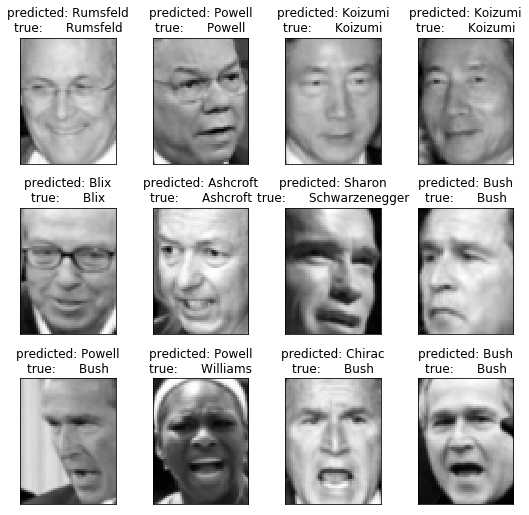

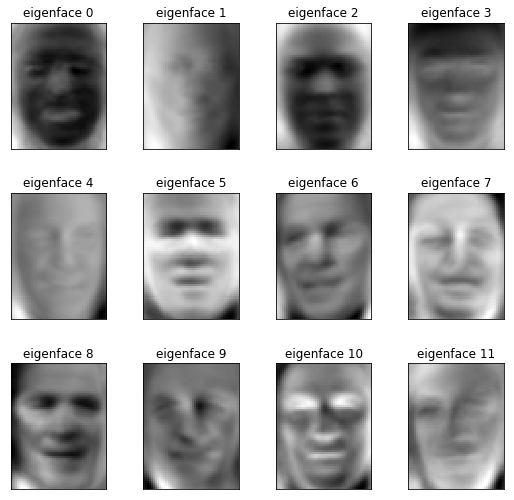

In [17]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()